Recommender Systems
=======================
Using per-item features
-----------------------
Suppose that we know the features of each movie, e.g, genre, director, actors, etc.
n_u = 4 -> number of users
n_m = 5 -> number of movies
n = 2 -> number of features
x1 and x2 are indicators of the genre of the movie, e.g, x1 = 0.9, x2 = 0.1 means that the movie is 90% romance and 10% action.
For user j: predict rating for movie i as: w(j).x(i) + b(j) ---> just like linear regression. x(i) is the feature vector of movie i.

The cost function
------------------
Notations:
- R(i,j) = 1 if user j has rated movie i
- y(i,j) = rating by user j on movie i (if R(i,j) = 1)
- x(i) = feature vector of movie i
- w(j), b(j) = parameters for user j
- for user j and movie i, the predicted rating is: w(j).x(i) + b(j)
- m(j) = number of movies rated by user j
- min J(w(j), b(j)) = (1/2m(j)) * sum((w(j).x(i) + b(j) - y(i,j))^2) for all movies i rated by user j
- The regularization term is: lambda/2m * sum(w(j)_k ^2) for all features k
Note: It turns out that for recommender system eliminating the 'm' in the denominator is better. So, the cost function for user j becomes:
- J(w(j), b(j)) = (1/2) * sum((w(j).x(i) + b(j) - y(i,j))^2) + (lambda/2) * sum(w(j)_k ^2) for all movies i rated by user j

Collaborative Filtering
-------------------------
What if we don't have features for each movie? We can use collaborative filtering.
- We can learn the features from the data.
- In this case the parameters x(i) are unknown.
- using w(j).x(i) + b(j): we can have some equations and figure out what x(i) should be. --> w1.x1 ~ 5, w2.x1 ~ 2, etc.
- This works because we have parameters w(j) and b(j) for each user j.
- The cost function for collaborative filtering is:
- to learn x(i), J(x(i)) = (1/2) * sum((w(j).x(i) + b(j) - y(i,j))^2) + (lambda/2) * sum(x(i)_k ^2) for all users j who rated movie i
- to learn x(1), x(2), ..., x(n_m), we minimize the sum of the cost functions for each movie i.
- But so far we assumed that we know w(j) and b(j).
- So the collaborative filtering algorithm is using the cost function for learning x(i) and the cost function for learning w(j) and b(j) together.
- Putting the two cost functions above together, we get:
- 1/2 * sum((w(j).x(i) + b(j) - y(i,j))^2) + (lambda/2) * sum(w(j)_k ^2) + (lambda/2) * sum(x(i)_k ^2) for all pairs of (i,j) where R(i,j) = 1

- How to minimize this cost function? gradient descent.
- repeat {
- w(j) = w(j) - alpha * dJ(w,b,x)/dw(j) 
- b(j) = b(j) - alpha * dJ(w,b,x)/db(j)
- x(i) = x(i) - alpha * dJ(w,b,x)/dx(i)
- }
- So the algorithm takes 3 parameters: w(j), b(j), x(i) and updates them simultaneously.
Note: This works because multiple users rate multiple movies. If a user rates only one movie, we can't learn the features of the movie.

Binary Labels: favs, likes and clicks
--------------------------------------
Sometimes the data is not a rating, but a binary label, e.g, 0 or 1, indicating whether the user liked the item or not.
The process is very much similar to what we saw in course 1, going from linear regression to logistic regression.
Example applications of labeling 1, 0, ?:
- Did user j purchase an item after being shown?
- Did user j fav/like an item?
- Did user j spend at least 30sec with the item?
- Did user j click on the item?

1: engaged after being shown the item
0: not engaged after being shown the item
?: item not shown yet

So the algorithm,
previously: w(j).x(i) + b(j) = y(i,j)
now: predict that the probability of y(i,j) = 1 is: g(w(j).x(i) + b(j)), where g is 1/(1 + e^(-z)).
So, the cost function becomes:  -> assuming f(w,b,x) = g(w(j).x(i) + b(j))
- Loss(f(w,b,x), y(i,j)) = -y(i,j) * log(f(w,b,x)) - (1-y(i,j)) * log(1 - f(w,b,x)) -> for single example
- J(w,b,x) = sum(Loss(f(w,b,x), y(i,j))) for all examples where r(i,j) = 1

Recommender Systems Implementation
===================================
Mean Normalization
-------------------
Suppose a new user is introduced and has not rated any movie yet. So, the prediction for the user will be all zeros for all movies; because the algorithm will learn the parameters for the user as w=0, b=0.
But with mean normalization, the predictions will be much more accurate.
- mu = mean of all ratings by all users who have given ratings for each movie
- Then, we subtract mu from the ratings of each user for each movie.
- So, the prediction for users will be:
- w(j).x(i) + b(j) + mu(i) -> mu(i) is the mean rating for movie i
- So for the new user, the prediction will be mu(i) for all movies.

An alternative would be to normalize the columns instead of the rows, but this approach works better when a new movie is introduced.

In [5]:
import keras
import numpy as np


ratings = np.array([[4, 0, 2, 5, 0], [0, 5, 0, 3, 2], [2, 0, 3, 4, 0], [5, 4, 3, 0, 0]])
print(ratings)

# mean normalization
mu = np.mean(ratings, axis=-1).reshape(-1, 1)
print(mu)

ratings_normalized = ratings - mu
print(ratings_normalized)

[[4 0 2 5 0]
 [0 5 0 3 2]
 [2 0 3 4 0]
 [5 4 3 0 0]]
[[2.2]
 [2. ]
 [1.8]
 [2.4]]
[[ 1.8 -2.2 -0.2  2.8 -2.2]
 [-2.   3.  -2.   1.   0. ]
 [ 0.2 -1.8  1.2  2.2 -1.8]
 [ 2.6  1.6  0.6 -2.4 -2.4]]


Tensorflow Implementation
-------------------------
Tensorflow can help you automatically compute the derivatives and update the parameters. ---> Auto Diff
Let's see the code:

In [2]:
import tensorflow as tf


w = tf.Variable(3.0)    # initial value of w, w is a parameter we want to optimize
x = 1.0
y = 1.0
alpha = 0.01    # learning rate
iterations = 30

for i in range(iterations):
    # Use tensorflow's GradientTape to record the steps
    # used to compute the costJ, to enable auto differentiation
    with tf.GradientTape() as tape:
        fwb = w * x
        costJ = (fwb - y)**2
    
    # Use the gradient tape to calculate the gradients
    # of the cost with respect to parameter w
    gradient = tape.gradient(costJ, w)
    # Run one step of gradient descent by updating
    # the value of w to reduce the cost
    w.assign_add(-alpha * gradient)
    print(f'iteration {i}: loss = {costJ.numpy()}, w = {w.numpy()}')

iteration 0: loss = 4.0, w = 2.9600000381469727
iteration 1: loss = 3.841600179672241, w = 2.920799970626831
iteration 2: loss = 3.6894724369049072, w = 2.8823840618133545
iteration 3: loss = 3.543369770050049, w = 2.844736337661743
iteration 4: loss = 3.4030520915985107, w = 2.8078415393829346
iteration 5: loss = 3.2682909965515137, w = 2.7716846466064453
iteration 6: loss = 3.138866424560547, w = 2.736250877380371
iteration 7: loss = 3.0145671367645264, w = 2.701525926589966
iteration 8: loss = 2.895190477371216, w = 2.6674954891204834
iteration 9: loss = 2.780541181564331, w = 2.634145498275757
iteration 10: loss = 2.670431613922119, w = 2.6014626026153564
iteration 11: loss = 2.5646824836730957, w = 2.5694334506988525
iteration 12: loss = 2.4631214141845703, w = 2.5380446910858154
iteration 13: loss = 2.365581512451172, w = 2.5072836875915527
iteration 14: loss = 2.271904230117798, w = 2.477138042449951
iteration 15: loss = 2.181936740875244, w = 2.4475953578948975
iteration 16: lo

so the main work that needs to be done is to define the cost function for Tensorflow.
Note: With tensorflow, you can use not just gradient descent, but more advanced optimization algorithms, like the Adam optimizer.

Finding Related Items
---------------------
The features x(i) of item i can be hard to interpret.
But all the x(i) features collectively can tell us sth about the item.
To find other items related to item i:
- find item k with x(k) similar to x(i)
- to calculate the similarity, use the squared distance formula for the two vectors: ||x(i) - x(k)||^2

Limitations of Collaborative Filtering
-----------------------
1. Cold start problem: what if a new user or a new item is introduced?
2. Use side information about items or users:
    - Item: genre, movie stars, studio,...
    - User: demographics, expressed preferences,...

Content-Based Filtering
=======================
Content-Based Filtering vs. Collaborative Filtering
----------------------------------------------------
- Collaborative filtering: Recommend items to you based on ratings of other users who gave similar ratings as you.
- Content-based filtering: Recommend items to you based on the features of users and item to find good match.

Examples of user and item features:
- user: age, gender, country, movies watched, avg rating per genre,...  --> x_u(j) for user j
- movie: year, genre, reviews, avg rating,... --> x_m(i) for movie i

Learning to Match
-----------------
Predict rating of user j on movie i as:
- V_u(j).V_m(i)  --> dot product of the feature vectors of user j and movie i
- V_u(j) is computed from x_u(j) and V_m(i) is computed from x_m(i)
- But how can we compute the two vectors such that they compactly represent user's preferences and movie's features?
- Note that while x_u and x_m can be in any dimension, the v_u and v_m vectors must be exactly of the same dimension.

Deep Learning for Content-Based Filtering
=========================================
We will have two networks, one for users and one for movies.
- The user network will take the user's features and output the user's preferences vector.
- The movie network will take the movie's features and output the movie's features vector.
- Note that the networks can have different architectures, except for the last layer where the output vectors must have the same dimension.
- Then the prediction will be: V_u(j).V_m(i)
- If we have binary labels, then we can pass the dot product to a sigmoid function to get the probability of the user liking the movie.

The cost function will be:
J = sum(V_u(j).V_m(i) - y(i,j))^2 for all pairs of (i,j) where R(i,j) = 1 + neural network regularization term
So there's no separate procedure for the user and movie networks, they are trained together.

It turns out that you can use this algorithm to find similar items as we saw in collaborative filtering.
- Suppose we have V_u(j) and V_m(i) for user j and movie i.
- So, the vector describing movie i is V_u(i)
- To find similar movies to movie i, we can find movies with similar V_m(i) vectors; that is min ||V_m(i) - V_m(k)||^2.

Note: This can be pre-computed ahead of time, meaning you can run the algorithm overnight and then show the user tomorrow.

Recommending for a Large Catalogue
===================================
A recommender system might have to recommend from a large catalogue of items.
How do we do it that is computationally efficient?

One way is to use a two-step process(retrieval and ranking):
- Retrieval: Generate large list of plausible item candidates
- 1. for each of the last 10 movies watched by the user, find 10 most similar movies
- 2. for most viewed 3 genres, find the top 10 movies
- 3. top 20 movies in the country
In this step, we are using the pre-computed list of similar movies to create a list of movies the user might like (plausible candidates).
The main goal of Retrieval is good coverage, to have enough movies that the user will like some of them.
- 4. combine retrieved items into list, removing duplicates and items already watched/purchased

- Ranking: Rank the list of plausible candidates using the learned model

- How many items should we feed the network as input?
- Retrieving more items results in better performance, but slower recommendations.
- To analyze/optimize the trade-off, carry out offline experiments to see if retrieving additional items results in more relevant recommendations (i.e., p(y(i,j) = 1) of items displayed to user are higher).

Principal Component Analysis (PCA)
===================================
PCA is a dimensionality reduction algorithm.
- It can be used to reduce the number of features of a dataset.
- It can be used to compress the data.
- It can be used to visualize high-dimensional data.
- It can be used to speed up learning algorithms.
- It can be used to remove noise from data.
- It can be used to find patterns in data.
- It can be used to find the directions of maximum variance in data.

PCA is a linear transformation:
- It rotates the data so that the rotated features are statistically uncorrelated.
- It projects the data onto the rotated features.
- It sorts the rotated features by decreasing variance.
- It selects the first k rotated features to reduce the dimensionality of the data.
- The first k rotated features are the principal components of the data.
- The first principal component is the direction in which the data varies the most.
- The k-th principal component is the direction in which the data varies the k-th most.

The algorithm:
- Normalize the data.
- Compute the covariance matrix of the data.
- Compute the eigenvectors of the covariance matrix.
- Select the first k eigenvectors.
- Project the data onto the selected eigenvectors.
- The projected data is the reduced data.
- The eigenvectors are the principal components.
- The eigenvalues are the variances of the principal components.
- The variance of the data is the sum of the eigenvalues.
- The variance retained by the reduced data is the sum of the k largest eigenvalues divided by the sum of all eigenvalues.

Note: PCA can also be used to reconstruct the data back to its original dimensionality approximately.

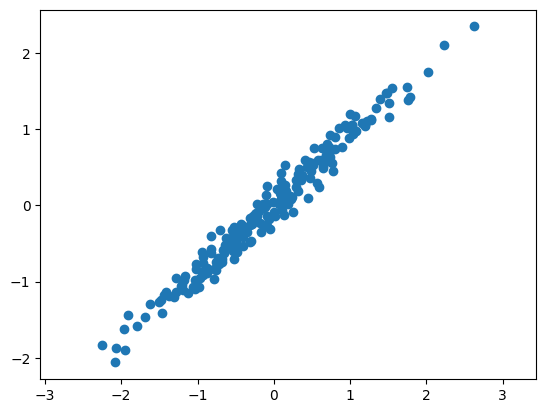

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# generate some data
np.random.seed(0)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

In [2]:
# PCA
pca = PCA(n_components=1)
pca

PCA(n_components=1)

In [3]:
X_pca = pca.fit_transform(X)

In [7]:
X_pca[:5]

array([[ 2.17116202],
       [-2.15933307],
       [ 0.83140174],
       [-0.70178482],
       [ 0.24902873]])

In [4]:
pca.explained_variance_ratio_

array([0.99293528])

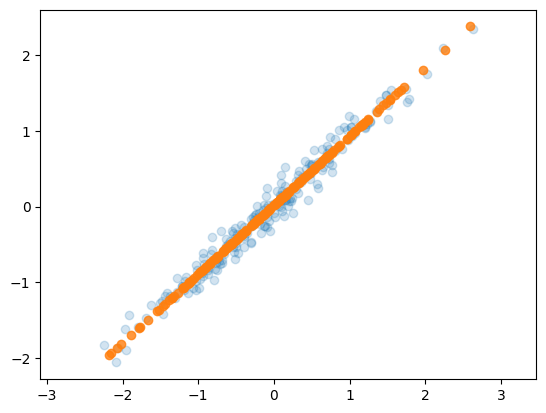

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal')
plt.show()